In [ ]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn opencv-python 
%matplotlib inline

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import skimage
import random 
import numpy as np
import matplotlib.pyplot as plt  
from skimage import exposure, filters, measure
from scipy import ndimage

In [7]:
%pip install keras_preprocessing

Note: you may need to restart the kernel to use updated packages.


In [8]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'

image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])

## Parse annotation xml files to into a single dataframe (df)

In [24]:
#  Parse XML annotations and create DataFrame
def parse_xml_annotation(xml_path):
    """Parse XML file and extract annotations"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get image info
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        # Extract objects
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            bbox = {
                'xmin': int(bndbox.find('xmin').text),
                'ymin': int(bndbox.find('ymin').text),
                'xmax': int(bndbox.find('xmax').text),
                'ymax': int(bndbox.find('ymax').text)
            }
            objects.append({'class': name, 'bbox': bbox})
        
        return {
            'filename': filename,
            'width': width,
            'height': height,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

dataset_info = []

xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
if len(xml_files) == 0:
    print(f"Warning: No XML files found in {annotations_pth}")

for xml_file in xml_files:
    xml_path = os.path.join(annotations_pth, xml_file)
    annotation = parse_xml_annotation(xml_path)
    
    if annotation:
        dataset_info.append({
            'image_name': annotation['filename'],
            'image_path': os.path.join(dataset_pth, annotation['filename']),
            'xml_path': xml_path,
            'width': annotation['width'],
            'height': annotation['height'],
            'num_objects': len(annotation['objects']),
            'objects': annotation['objects']
        })

df = pd.DataFrame(dataset_info)
%store df

print(f"Created DataFrame with {len(df)} samples")
df.head()
df.tail()

Stored 'df' (DataFrame)
Created DataFrame with 3231 samples


,image_name,image_path,xml_path,width,height,num_objects,objects
3226,\t230.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,784,334,2,"[{'class': 'Normal Flow', 'bbox': {'xmin': 101..."
3227,\t231.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,784,330,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3228,\t232.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,781,330,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3229,\t233.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,788,326,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3230,\t234.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,780,328,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."


## Explore Dataset for Unconsistence data

In [10]:
print("Checking for inconsistencies, missing files, and data issues...\n")

# Initialize counters
issues_found = 0
image_sizes = []
missing_images = []
missing_xmls = []
xml_parsing_errors = []

# 1. Check image-XML correspondence
print("CHECKING IMAGE-XML CORRESPONDENCE:")
for i, xml_file in enumerate(xml_files):
    # show progress occasionally
    if i % 500 == 0:
        print(f"   Checked {i}/{len(xml_files)} files...")
    
    xml_path = os.path.join(annotations_pth, xml_file)
    
    # Parse XML to get expected image filename
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        expected_image = root.find('filename').text

        # Normalize filename (strip whitespace/tabs)
        if expected_image is not None:
            expected_image = expected_image.strip()
        else:
            raise ValueError("Missing <filename> tag in XML")

        # Check if image exists
        image_path = os.path.join(dataset_pth, expected_image)
        if not os.path.exists(image_path):
            missing_images.append((xml_file, expected_image))
            issues_found += 1

    except Exception as e:
        xml_parsing_errors.append((xml_file, str(e)))
        issues_found += 1

# Summary
print(f"Finished checking {len(xml_files)} xml files.")
print(f"Missing images: {len(missing_images)}, XML parse errors: {len(xml_parsing_errors)}, issues_found: {issues_found}")
print(f"The missing images are: {missing_images}")


Checking for inconsistencies, missing files, and data issues...

CHECKING IMAGE-XML CORRESPONDENCE:
   Checked 0/3231 files...
   Checked 500/3231 files...
   Checked 1000/3231 files...
   Checked 1500/3231 files...
   Checked 2000/3231 files...
   Checked 2500/3231 files...
   Checked 3000/3231 files...
Finished checking 3231 xml files.
Missing images: 316, XML parse errors: 0, issues_found: 316
The missing images are: [('normal_pressure_1.xml', '136.png'), ('normal_pressure_10.xml', '145.png'), ('normal_pressure_100.xml', '235.png'), ('normal_pressure_101.xml', '236.png'), ('normal_pressure_102.xml', '237.png'), ('normal_pressure_103.xml', '238.png'), ('normal_pressure_104.xml', '239.png'), ('normal_pressure_105.xml', '240.png'), ('normal_pressure_106.xml', '241.png'), ('normal_pressure_107.xml', '242.png'), ('normal_pressure_108.xml', '243.png'), ('normal_pressure_109.xml', '244.png'), ('normal_pressure_11.xml', '146.png'), ('normal_pressure_110.xml', '245.png'), ('normal_pressure_1

In [11]:
print("\nCHECKING ALL IMAGES HAVE XML ANNOTATIONS:")

# Ensure image_files list is available; if not, build it from dataset_pth
try:
    image_files  # check if variable exists
except NameError:
    image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])

# Ensure missing_xmls and issues_found exist
if 'missing_xmls' not in globals():
    missing_xmls = []
if 'missing_images' not in globals():
    missing_images = []
if 'issues_found' not in globals():
    issues_found = 0

for img_file in image_files:
    expected_xml = img_file.rsplit('.', 1)[0] + '.xml'
    xml_path = os.path.join(annotations_pth, expected_xml)
    
    if not os.path.exists(xml_path):
        missing_xmls.append(img_file)
        issues_found += 1

print(f"Checked {len(image_files)} images\nImages that are missing XML annotations: {len(missing_xmls)}\nTotal annotations that don't have corresponding images so far: {issues_found}")



CHECKING ALL IMAGES HAVE XML ANNOTATIONS:
Checked 3231 images
Images that are missing XML annotations: 0
Total annotations that don't have corresponding images so far: 316


In [12]:
print("\nCHECKING IMAGE PROPERTIES:")
unique_formats = set()
corrupted_images = []


for img_file in image_files:  
    try:
        img_path = os.path.join(dataset_pth, img_file)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
            unique_formats.add(img.format)
            
            # Check if image can be loaded properly
            img.load()  # This will fail for corrupted images
            
    except Exception as e:
        corrupted_images.append((img_file, str(e)))
        issues_found += 1

print(f"Sampled {len(image_sizes)} images for property checks.")
print(f"Unique image formats found: {unique_formats}")
print(f"Corrupted images found: {len(corrupted_images)}")


CHECKING IMAGE PROPERTIES:
Sampled 3231 images for property checks.
Unique image formats found: {'JPEG'}
Corrupted images found: 0


In [13]:
# Check XML structure consistency
print("\nCHECKING XML STRUCTURE CONSISTENCY:")
sample_xml_structure = None
inconsistent_xmls = []

for xml_file in xml_files[:10]:  # Check first 10 for structure
    try:
        xml_path = os.path.join(annotations_pth, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        current_structure = []
        for elem in root.iter():
            current_structure.append(elem.tag)
        
        if sample_xml_structure is None:
            sample_xml_structure = current_structure
        elif current_structure != sample_xml_structure:
            inconsistent_xmls.append(xml_file)
            issues_found += 1
            
    except Exception as e:
        xml_parsing_errors.append((xml_file, str(e)))
        issues_found += 1

print(f"Checked {len(xml_files)} XML files for structure consistency.")
print(f"Inconsistent XML structures found: {len(inconsistent_xmls)}")


CHECKING XML STRUCTURE CONSISTENCY:
Checked 3231 XML files for structure consistency.
Inconsistent XML structures found: 0


In [14]:
# Verify all images have the same size
sizes = []


for img_file in image_files[:50]:  # Check first 50 images
    img_path = os.path.join(dataset_pth, img_file)
    with Image.open(img_path) as img:
        sizes.append(img.size)

unique_sizes = set(sizes)
print(f"Unique image sizes in sample: {unique_sizes}")
print(f"All images have same size: {len(unique_sizes) == 1}")
print(f"Images Count: {len(sizes)}")

Unique image sizes in sample: {(515, 255), (515, 258), (516, 257), (516, 260), (517, 258), (517, 255), (514, 256), (514, 259), (516, 259), (515, 257), (512, 255), (517, 260), (514, 258), (514, 255), (516, 258), (515, 256), (516, 255), (516, 261), (515, 259), (513, 256), (513, 259), (512, 257)}
All images have same size: False
Images Count: 50


In [15]:
print("=== DATA QUALITY RESULTS ===")
print(f"Total issues found: {issues_found}")

if missing_images:
    print(f"\n MISSING IMAGES: {len(missing_images)}")
    for xml, missing_img in missing_images[:5]:  # Show first 5
        print(f"   XML: {xml} -> Image: {missing_img} (NOT FOUND)")

if missing_xmls:
    print(f"\nMISSING XML FILES: {len(missing_xmls)}")
    for img in missing_xmls[:5]:
        print(f"   Image: {img} -> XML: {img.rsplit('.', 1)[0] + '.xml'} (NOT FOUND)")

if corrupted_images:
    print(f"\n CORRUPTED IMAGES: {len(corrupted_images)}")
    for img, error in corrupted_images[:3]:
        print(f"   {img}: {error}")

if xml_parsing_errors:
    print(f"\n XML PARSING ERRORS: {len(xml_parsing_errors)}")
    for xml, error in xml_parsing_errors[:3]:
        print(f"   {xml}: {error}")

if inconsistent_xmls:
    print(f"\n INCONSISTENT XML STRUCTURES: {len(inconsistent_xmls)}")
    print(f"   Files with different XML structures: {inconsistent_xmls[:3]}")

# Image size analysis
if image_sizes:
    print(f"\nIMAGE SIZE ANALYSIS:")
    size_counts = pd.Series(image_sizes).value_counts()
    print(f"   Unique sizes: {len(size_counts)}")
    print(f"   Most common sizes:")
    for size, count in size_counts.head(5).items():
        print(f"     {size}: {count} images")
    
    print(f"   Size range: {min(image_sizes)} to {max(image_sizes)}")

print(f"\nDATASET OVERVIEW:")
print(f"   Total images: {len(image_files)}")
print(f"   Total XML files: {len(xml_files)}")
print(f"   Image formats: {unique_formats}")
print(f"   Corrupted images: {len(corrupted_images)}")

=== DATA QUALITY RESULTS ===


Total issues found: 316

 MISSING IMAGES: 316
   XML: normal_pressure_1.xml -> Image: 136.png (NOT FOUND)
   XML: normal_pressure_10.xml -> Image: 145.png (NOT FOUND)
   XML: normal_pressure_100.xml -> Image: 235.png (NOT FOUND)
   XML: normal_pressure_101.xml -> Image: 236.png (NOT FOUND)
   XML: normal_pressure_102.xml -> Image: 237.png (NOT FOUND)

IMAGE SIZE ANALYSIS:
   Unique sizes: 2534
   Most common sizes:
     (475, 147): 10 images
     (474, 147): 9 images
     (807, 329): 9 images
     (727, 329): 8 images
     (516, 255): 8 images
   Size range: (257, 225) to (1334, 614)

DATASET OVERVIEW:
   Total images: 3231
   Total XML files: 3231
   Image formats: {'JPEG'}
   Corrupted images: 0


In [16]:
print("=== CLEANING RECOMMENDATIONS ===")

if 'issues_found' not in globals():
    issues_found = 0
if 'missing_images' not in globals():
    missing_images = []
if 'missing_xmls' not in globals():
    missing_xmls = []
if 'corrupted_images' not in globals():
    corrupted_images = []
if 'empty_annotations' not in globals():
    empty_annotations = []
if 'invalid_bboxes' not in globals():
    invalid_bboxes = []
    
# size_counts may be a pandas Series; ensure it's available and non-empty
size_counts_available = 'size_counts' in globals() and getattr(size_counts, 'size', 0) > 0
recommendations = []


if issues_found == 0:
    print(" Dataset appears clean and consistent!")
else:
    print(f" Found {issues_found} issues that need addressing:")
    
    if missing_images or missing_xmls:
        recommendations.append("Fix file correspondence issues")
        
    if corrupted_images:
        recommendations.append("Remove or fix corrupted images")
        
    if size_counts_available and len(size_counts) > 1:
        # safe access to most common size
        try:
            recommended_size = size_counts.index[0]
        except Exception:
            recommended_size = None
        if recommended_size is not None:
            recommendations.append(f"Resize images to consistent size (recommended: {recommended_size})")
        else:
            recommendations.append("Resize images to consistent size")
        
    if empty_annotations:
        recommendations.append("Remove files with empty annotations")
        
    if invalid_bboxes:
        recommendations.append("Fix invalid bounding boxes")
    
    if recommendations:
        print("\nRecommended cleaning steps:")
        for i, rec in enumerate(recommendations, 1):
            print(f"   {i}. {rec}")
    else:
        print("\nNo specific automated recommendations could be derived. Please inspect the issues listed earlier.")

print(f"\nNext step: {'PROCEED TO MODEL TRAINING' if issues_found == 0 else 'ADDRESS DATA ISSUES FIRST'}")

=== CLEANING RECOMMENDATIONS ===
 Found 316 issues that need addressing:

Recommended cleaning steps:
   1. Fix file correspondence issues
   2. Resize images to consistent size (recommended: (475, 147))

Next step: ADDRESS DATA ISSUES FIRST


Dataset Overview:
Total images: 3231
Total annotations: 6538

Class Distribution:
Normal Flow                  849
Normal Volume                687
Accumulation Flow            562
Volume                       562
Premature_cycling Flow       476
Premature_cycling Volume     460
Flow                         452
Leakage Volume               452
Ineffective_effort Volume    438
Ineffective_effort Flow      438
Double_Triggering Volume     424
Double_Triggering Flow       422
Normal Pressure              316
Name: count, dtype: int64


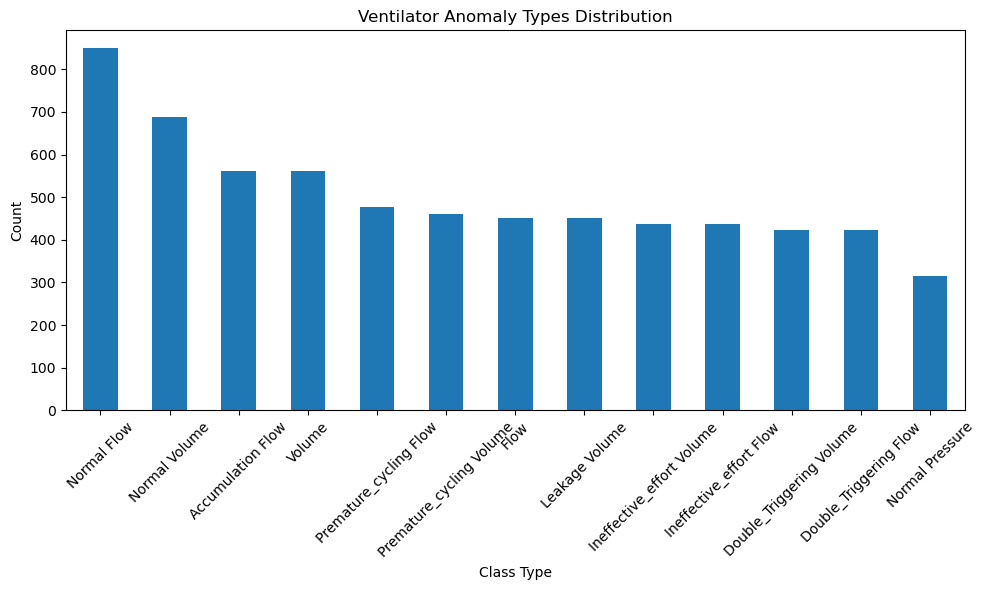

In [17]:
print("Dataset Overview:")
print(f"Total images: {len(df)}")
print(f"Total annotations: {df['num_objects'].sum()}")

all_classes = []
for objects in df['objects']:
    for obj in objects:
        all_classes.append(obj['class'])

class_counts = pd.Series(all_classes).value_counts()
print("\nClass Distribution:")
print(class_counts)

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Ventilator Anomaly Types Distribution')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Read Image samples with annotation bounding boxes

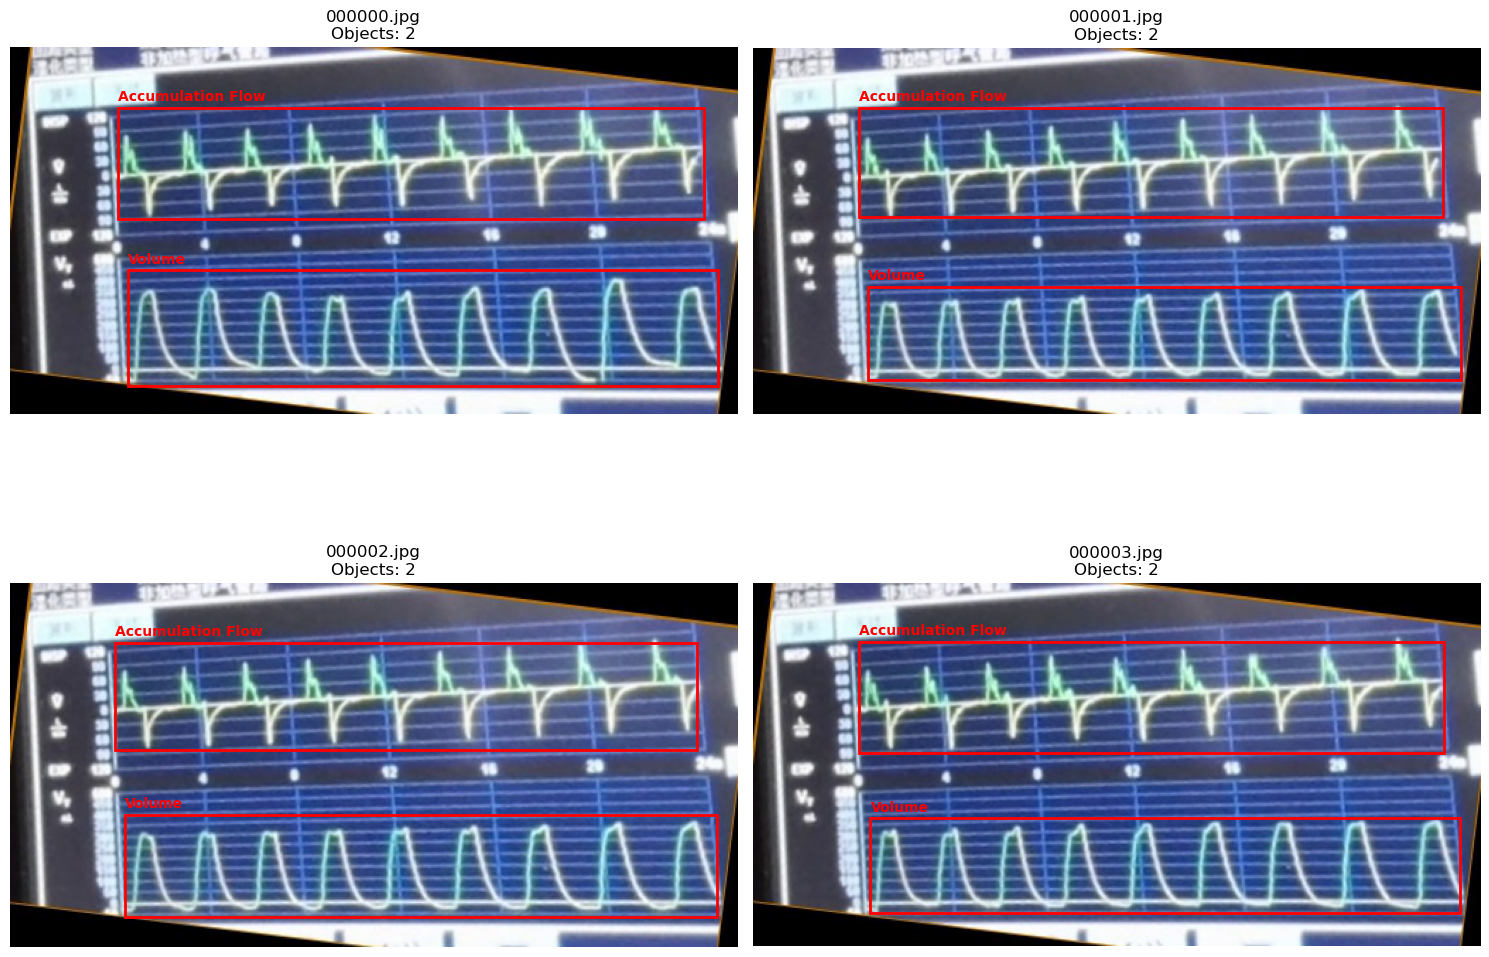

In [18]:
def plot_samples_with_boxes(df, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (_, row) in enumerate(df.head(num_samples).iterrows()):
        # Load image
        img = Image.open(row['image_path'])
        ax = axes[idx]
        ax.imshow(img)
        ax.set_title(f"{row['image_name']}\nObjects: {row['num_objects']}")
        
        # Draw bounding boxes
        for obj in row['objects']:
            bbox = obj['bbox']
            rect = plt.Rectangle(
                (bbox['xmin'], bbox['ymin']),
                bbox['xmax'] - bbox['xmin'],
                bbox['ymax'] - bbox['ymin'],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                bbox['xmin'], max(bbox['ymin'] - 5, 0),
                obj.get('class', ''), color='red', fontsize=10, weight='bold'
            )
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

try:
    cls = 'Accumulation Flow' 
except NameError:
    cls = 'Normal Flow'  

# Build boolean mask: True if any object in the row has the target class
mask = df['objects'].apply(lambda objs: any(o.get('class') == cls or o.get('class', '').startswith(cls) for o in objs))

filtered_df = df[mask]

if not filtered_df.empty:
    plot_samples_with_boxes(filtered_df)
else:
    print(f"No samples found for class '{cls}'")

##### preprocessing through grayscale conversion, Normalisation, Data Augmentation, Image standardization


### extra checks

## Calculate Image Nosie using ROI

#### check background reigon for noise

In [19]:
def measure_noise_manual_selection(image_path, region_description):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape
    # Different regions based on ventilator display layout
    regions = {
        'top_left': (10, 10, 50, 50),
        'top_right': (width-60, 10, 50, 50),
        'bottom_left': (10, height-60, 50, 50),
        'bottom_right': (width-60, height-60, 50, 50),
        'center_top': (width//2-25, 10, 50, 50)
    }
    
    if region_description in regions:
        x, y, w, h = regions[region_description]
        roi = img[y:y+h, x:x+w]
        
        print(f"{region_description}: STD = {roi.std():.2f}, Mean = {roi.mean():.2f}")
        return roi.std()
    else:
        print(f"Unknown region: {region_description}")
        return None

# Test different regions
print("=== TESTING DIFFERENT BACKGROUND REGIONS ===")
test_image = os.path.join(dataset_pth, image_files[0])

for region in ['top_left', 'top_right', 'bottom_left', 'bottom_right', 'center_top']:
    noise_std = measure_noise_manual_selection(test_image, region)
    print(f"Region: {region}, Noise STD: {noise_std}")

=== TESTING DIFFERENT BACKGROUND REGIONS ===
top_left: STD = 64.06, Mean = 191.16
Region: top_left, Noise STD: 64.05723889897222
top_right: STD = 55.87, Mean = 72.50
Region: top_right, Noise STD: 55.874706257482906
bottom_left: STD = 53.49, Mean = 54.75
Region: bottom_left, Noise STD: 53.48695243365432
bottom_right: STD = 57.67, Mean = 124.85
Region: bottom_right, Noise STD: 57.6729907197468
center_top: STD = 23.02, Mean = 84.30
Region: center_top, Noise STD: 23.024968707904907


#### use ROI to calculate noise level to check if dataset need clean 

In [ ]:
def measure_medical_noise(image_input):
    # Load image as grayscale
    if isinstance(image_input, str):
        img = cv2.imread(image_input, cv2.IMREAD_GRAYSCALE)
    else:
        img_np = np.array(image_input)
        if len(img_np.shape) == 3:
            img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            img = img_np
    
    # Step 1: Get the SIGNAL (medical content) using strong Gaussian blur
    # This preserves the overall waveform patterns but removes noise
    signal = cv2.GaussianBlur(img, (15, 15), 5)
    
    # Step 2: Extract NOISE by subtracting signal from original
    # This gives us the high-frequency components (actual noise)
    noise_component = img.astype(float) - signal.astype(float)
    
    # Step 3: Measure noise in background regions only
    # Avoid areas with medical content (waveforms, text, etc.)
    height, width = img.shape
    
    # Define safe background regions (corners, edges)
    background_regions = [
        noise_component[10:60, 10:60],           # top-left
        noise_component[10:60, width-60:width-10], # top-right
        noise_component[height-60:height-10, 10:60], # bottom-left
        noise_component[height-60:height-10, width-60:width-10] # bottom-right
    ]
    
    # Calculate noise standard deviation in background
    background_noise = np.concatenate([region.flatten() for region in background_regions])
    noise_std = np.std(background_noise)
    
    if noise_std < 1.0:
        classification = "Excellent"
        needs_denoising = False
    elif noise_std < 2.5:
        classification = "Very Good"
        needs_denoising = False
    elif noise_std < 5.0:
        classification = "Good"
        needs_denoising = "Optional"
    elif noise_std < 10.0:
        classification = "Moderate"
        needs_denoising = True
    elif noise_std < 20.0:
        classification = "Noisy"
        needs_denoising = True
    else:
        classification = "Very Noisy"
        needs_denoising = True
    
    return {
        'noise_std': noise_std,
        'classification': classification,
        'needs_denoising': needs_denoising,
        'signal_image': signal,
        'noise_image': noise_component
    }

=== TESTING ACCURATE NOISE MEASUREMENT ===
image 000000.jpg: Noise STD: 31.16, Classification: Very Noisy
image 000001.jpg: Noise STD: 30.91, Classification: Very Noisy


In [30]:
print("\n=== NOISE ASSESSMENT ===")
final_results = []

for imagefile in image_files[:10]:
    image_path = os.path.join(dataset_pth, imagefile)
    result = measure_medical_noise(image_path)
    
    print(f"{imagefile}: {result['classification']} (STD: {result['noise_std']:.1f}) - Denoise: {result['needs_denoising']}")
    final_results.append(result)

noise_levels = [r['noise_std'] for r in final_results]
avg_noise = np.mean(noise_levels)

print(f"\n DATASET NOISE SUMMARY:")
print(f"Average noise STD: {avg_noise:.1f}")
print(f"Noise range: {min(noise_levels):.1f} - {max(noise_levels):.1f}")

if avg_noise < 15:
    print(" RECOMMENDATION: Skip noise reduction - images are clean")
elif avg_noise < 25:
    print(" RECOMMENDATION: Optional gentle denoising")
else:
    print(" RECOMMENDATION: Apply gentle denoising")


=== NOISE ASSESSMENT ===
000000.jpg: Very Noisy (STD: 31.2) - Denoise: True
000001.jpg: Very Noisy (STD: 30.9) - Denoise: True
000002.jpg: Very Noisy (STD: 30.9) - Denoise: True
000003.jpg: Very Noisy (STD: 31.6) - Denoise: True
000004.jpg: Very Noisy (STD: 31.3) - Denoise: True
000005.jpg: Very Noisy (STD: 27.1) - Denoise: True
000006.jpg: Very Noisy (STD: 30.9) - Denoise: True
000007.jpg: Very Noisy (STD: 30.9) - Denoise: True
000008.jpg: Very Noisy (STD: 29.4) - Denoise: True
000009.jpg: Very Noisy (STD: 31.1) - Denoise: True

 DATASET NOISE SUMMARY:
Average noise STD: 30.5
Noise range: 27.1 - 31.6
 RECOMMENDATION: Apply gentle denoising


#### heck if Normalization applied to data

=== CHECKING CURRENT PIXEL VALUE RANGE ===
Current Pixel Value Ranges:
     filename  min  max        mean
0  000000.jpg    0  255  111.356900
1  000001.jpg    0  255  115.213070
2  000002.jpg    0  255  115.120564
3  000003.jpg    0  255  110.948555
4  000004.jpg    0  255  111.378611
5  000005.jpg    0  255  118.097941
6  000006.jpg    0  255  114.949073
7  000007.jpg    0  255  114.709813
8  000008.jpg    0  255  111.638347
9  000009.jpg    0  255  113.342583

Overall Statistics:
Global min: 0
Global max: 255
Global mean: 113.7
Global std: 65.0
=== VISUALIZING PIXEL VALUE DISTRIBUTION ===


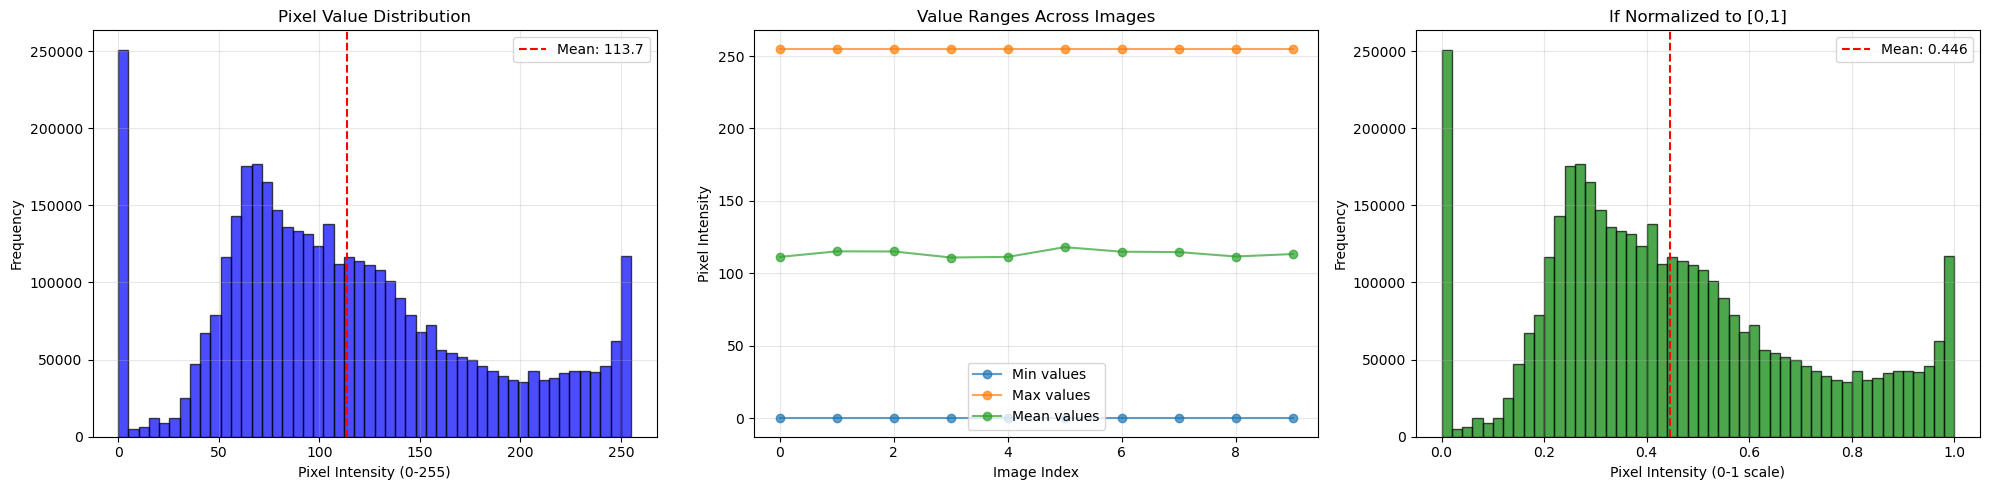

In [21]:
# Check Current Pixel Value Range
print("=== CHECKING CURRENT PIXEL VALUE RANGE ===")

def analyze_pixel_distribution(image_paths, sample_size=10):
    all_pixels = []
    value_ranges = []
    
    for img_file in image_paths[:sample_size]:
        img_path = os.path.join(dataset_pth, img_file)
        image = cv2.imread(img_path)
        
        if image is not None:
            # Convert to RGB and flatten
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pixels = image_rgb.ravel()
            all_pixels.extend(pixels)
            
            value_ranges.append({
                'filename': img_file,
                'min': pixels.min(),
                'max': pixels.max(),
                'mean': pixels.mean(),
                'std': pixels.std()
            })
    
    return all_pixels, value_ranges

# Analyze current distribution
pixels, ranges = analyze_pixel_distribution(image_files)
ranges_df = pd.DataFrame(ranges)

print("Current Pixel Value Ranges:")
print(ranges_df[['filename', 'min', 'max', 'mean']].head(10))

print(f"\nOverall Statistics:")
print(f"Global min: {np.min(pixels)}")
print(f"Global max: {np.max(pixels)}")
print(f"Global mean: {np.mean(pixels):.1f}")
print(f"Global std: {np.std(pixels):.1f}")

# Visualize Current Distribution
print("=== VISUALIZING PIXEL VALUE DISTRIBUTION ===")

plt.figure(figsize=(20, 5))

# Plot 1: Histogram of all pixel values
plt.subplot(1, 3, 1)
plt.hist(pixels, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.mean(pixels), color='red', linestyle='--', label=f'Mean: {np.mean(pixels):.1f}')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')
plt.title('Pixel Value Distribution')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Value ranges per image
plt.subplot(1, 3, 2)
plt.plot(ranges_df['min'], 'o-', label='Min values', alpha=0.7)
plt.plot(ranges_df['max'], 'o-', label='Max values', alpha=0.7)
plt.plot(ranges_df['mean'], 'o-', label='Mean values', alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Pixel Intensity')
plt.title('Value Ranges Across Images')
plt.legend()
plt.grid(alpha=0.3)

# Plot 3: is Data normalized?
plt.subplot(1, 3, 3)
normalized_pixels = np.array(pixels) / 255.0
plt.hist(normalized_pixels, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.axvline(np.mean(normalized_pixels), color='red', linestyle='--', label=f'Mean: {np.mean(normalized_pixels):.3f}')
plt.xlabel('Pixel Intensity (0-1 scale)')
plt.ylabel('Frequency')
plt.title('If Normalized to [0,1]')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
print("=== NORMALIZATION STATUS ANALYSIS ===")
# Check if data is already in common normalized ranges
is_0_255_scale = (np.max(pixels) > 1.0 and np.max(pixels) <= 255.0)
is_0_1_scale = (np.max(pixels) <= 1.0)
is_neg1_1_scale = (np.min(pixels) >= -1.0 and np.max(pixels) <= 1.0)

print(f"Data appears to be on scale: ")
print(f"  [0, 255] scale: {is_0_255_scale}")
print(f"  [0, 1] scale: {is_0_1_scale}")
print(f"  [-1, 1] scale: {is_neg1_1_scale}")

if is_0_255_scale:
    print("CONCLUSION: Data is in standard 0-255 range")
    print("   Normalization to [0,1] is REQUIRED for ML models")
elif is_0_1_scale:
    print("CONCLUSION: Data is already normalized to [0,1]")
    print("   No additional normalization needed")
elif is_neg1_1_scale:
    print("CONCLUSION: Data is normalized to [-1,1]")
    print("   Check if your model expects this range")
else:
    print("CONCLUSION: Unknown scale - investigate further")

=== NORMALIZATION STATUS ANALYSIS ===
Data appears to be on scale: 
  [0, 255] scale: True
  [0, 1] scale: False
  [-1, 1] scale: False
CONCLUSION: Data is in standard 0-255 range
   Normalization to [0,1] is REQUIRED for ML models


In [23]:
# IMAGE QUALITY ASSESSMENT
def analyze_image_quality(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Basic statistics
    height, width = image_gray.shape
    mean_intensity = np.mean(image_gray)
    std_intensity = np.std(image_gray)
    
    # Contrast assessment
    contrast = image_gray.max() - image_gray.min()
    
    # Noise assessment using ROI
    height, width = image_gray.shape
    roi_width, roi_height = 100, 100
    x = width // 2 - roi_width // 2
    y = 20  # margin 
    x = max(10, min(x, width - roi_width - 10))
    y = max(10, min(y, height - roi_height - 10))
    roi = image_gray[y:y+roi_height, x:x+roi_width]
    noise_std = np.std(roi)
    noise_mean = np.mean(roi)
    roi_coords= (x, y, roi_width, roi_height)
    
    # Sharpness assessment using gradient magnitude
    gy, gx = np.gradient(image_gray.astype(float))
    sharpness = np.mean(gx**2 + gy**2)
    
    dynamic_range = image_gray.max() - image_gray.min()
    
    return {
        'size': (width, height),
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'contrast': contrast,
        'noise_std': noise_std,
        'sharpness': sharpness,
        'dynamic_range': dynamic_range
    }

sample_images = image_files[:10]  
quality_metrics = []

print("Analyzing image quality for sample images...")
for img_file in sample_images:
    img_path = os.path.join(dataset_pth, img_file)
    metrics = analyze_image_quality(img_path)
    metrics['filename'] = img_file
    quality_metrics.append(metrics)

quality_df = pd.DataFrame(quality_metrics)
print("\nImage Quality Summary:")
print(quality_df[['filename', 'size', 'mean_intensity', 'contrast', 'noise_std']].head(10))

Analyzing image quality for sample images...

Image Quality Summary:
     filename        size  mean_intensity  contrast  noise_std
0  000000.jpg  (514, 259)      105.300340       255  46.555255
1  000001.jpg  (515, 259)      108.953436       255  44.678550
2  000002.jpg  (515, 258)      108.875728       255  44.819154
3  000003.jpg  (515, 257)      104.786461       255  46.555382
4  000004.jpg  (516, 258)      105.304714       255  47.218437
5  000005.jpg  (517, 258)      111.505803       255  46.367310
6  000006.jpg  (515, 258)      108.640250       255  44.297107
7  000007.jpg  (516, 258)      108.448027       254  45.161165
8  000008.jpg  (517, 260)      105.622080       255  44.997835
9  000009.jpg  (513, 259)      107.323609       255  44.668624


#### Quality Interpretation shows that:
Excellent Contrast: Maximum contrast range (254-255) ensures clear waveform visibility
Consistent Brightness: Narrow intensity range (104-111) indicates stable acquisition
Need to be Considerated:
Size Standardization Required: Despite small variations, fixed input dimensions are needed for neural networks 
Moderate Noise: Noise levels (STD 44-47) may benefit from filtering while preserving medical details
Normalize pixel values to [0,1] range for model training IMPORTANT

normalization, noise reduction, edge preservation, resizing

### NOTE: DATA AUGMENTATION could be critical for medical images need to be reviewed carefully based on clinical relevance